In [1]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.utils import shuffle

from collections import Counter, defaultdict

import json
from collections import defaultdict
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns
# sns.set()
sns.set_style("whitegrid")

In [3]:
import sys
sys.path.append('..')
from src import debias

In [4]:
def load_data(path, size, ratio=0.5):
    fnames = ["neg_neg.npy", "neg_pos.npy", "pos_neg.npy", "pos_pos.npy"]
    protected_labels = [0, 1, 0, 1]
    main_labels = [0, 0, 1, 1]
    X, Y_p, Y_m = [], [], []
    n1 = int(size * ratio / 2)
    n2 = int(size * (1 - ratio) / 2)
#     print(n1, n2)

    for fname, p_label, m_label, n in zip(fnames, protected_labels, main_labels, [n1, n2, n2, n1]):
#         print(path + '/' + fname)
#         print(np.load(path + '/' + fname).shape)
        data = np.load(path + '/' + fname)[:n]
        for x in data:
            X.append(x)
        for _ in data:
            Y_p.append(p_label)
        for _ in data:
            Y_m.append(m_label)

    Y_p = np.array(Y_p)
    Y_m = np.array(Y_m)
    X = np.array(X)
    X, Y_p, Y_m = shuffle(X, Y_p, Y_m, random_state=0)
    return X, Y_p, Y_m

In [5]:
def get_TPR(y_main, y_hat_main, y_protected):
    
    all_y = list(Counter(y_main).keys())
    
    protected_vals = defaultdict(dict)
    for label in all_y:
        for i in range(2):
            used_vals = (y_main == label) & (y_protected == i)
            y_label = y_main[used_vals]
            y_hat_label = y_hat_main[used_vals]
            protected_vals['y:{}'.format(label)]['p:{}'.format(i)] = (y_label == y_hat_label).mean()
            
    diffs = {}
    for k, v in protected_vals.items():
        vals = list(v.values())
        diffs[k] = vals[0] - vals[1]
    return protected_vals, diffs

In [51]:
get_TPR(y_m_dev, biased_classifier.predict(x_dev), y_p_dev)[1].values()

dict_values([-0.30746933667083864, 0.49425093867334163])

In [6]:
def rms(arr):
    return np.sqrt(np.mean(np.square(arr)))

In [7]:
results = defaultdict(dict)

for ratio in [0.5, 0.6, 0.7, 0.8]:

    x_train, y_p_train, y_m_train = load_data(
        '../data/emoji_sent_race_{}/train/'.format(ratio),
        size=100000, ratio=ratio)
    x_dev, y_p_dev, y_m_dev = load_data(
        '../data/emoji_sent_race_{}/test/'.format(ratio),
        size=100000, ratio=0.5)
    
    biased_classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

    biased_classifier.fit(x_train, y_m_train)
    biased_score = biased_classifier.score(x_dev, y_m_dev)
    
    P = np.load('../data/emoji_sent_race_{}/P_svm.num-clfs=300.npy'.format(ratio), allow_pickle=True)
    P = P[1]
    n_dims = 120
#     n_dims = 70
    if ratio == 0.5:
        n_dims = 200
    elif ratio == 0.6:
        n_dims = 100
    elif ratio == 0.7:
        n_dims = 115
    elif ratio == 0.8:
        n_dims = 200
    P = debias.get_projection_to_intersection_of_nullspaces(P[:n_dims], input_dim=300)
    
    debiased_x_train = P.dot(x_train.T).T
    debiased_x_dev = P.dot(x_dev.T).T

    classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

    classifier.fit(debiased_x_train, y_m_train)
    debiased_score = classifier.score(debiased_x_dev, y_m_dev)
    
    p_classifier = SGDClassifier(warm_start=True, loss='log', n_jobs=64, max_iter=10000, random_state=0, tol=1e-3)
    p_classifier.fit(debiased_x_train, y_p_train)
    p_score = p_classifier.score(debiased_x_dev, y_p_dev)
    results[ratio]['p_acc'] = p_score
    
    _, biased_diffs = get_TPR(y_m_dev, biased_classifier.predict(x_dev), y_p_dev)
    
    _, debiased_diffs = get_TPR(y_m_dev, classifier.predict(debiased_x_dev), y_p_dev)
    
#     results[ratio]['biased_diff_tpr'] = biased_diffs['y:0']
    results[ratio]['biased_diff_tpr'] = rms(list(biased_diffs.values()))
#     results[ratio]['debiased_diff_tpr'] = debiased_diffs['y:0']
    results[ratio]['debiased_diff_tpr'] = rms(list(debiased_diffs.values()))
    
    results[ratio]['biased_acc'] = biased_score
    results[ratio]['debiased_acc'] = debiased_score

In [13]:
results

defaultdict(dict,
            {0.5: {'p_acc': 0.517,
              'biased_diff_tpr': 0.19000000000000006,
              'debiased_diff_tpr': 0.16200000000000003,
              'biased_acc': 0.7595,
              'debiased_acc': 0.7525},
             0.6: {'p_acc': 0.6165,
              'biased_diff_tpr': 0.2891666666666667,
              'debiased_diff_tpr': 0.21500000000000008,
              'biased_acc': 0.783,
              'debiased_acc': 0.7375},
             0.7: {'p_acc': 0.623,
              'biased_diff_tpr': 0.3771428571428571,
              'debiased_diff_tpr': 0.24095238095238097,
              'biased_acc': 0.8085,
              'debiased_acc': 0.6645},
             0.8: {'p_acc': 0.6331331331331331,
              'biased_diff_tpr': 0.44906407035175877,
              'debiased_diff_tpr': 0.15108668341708542,
              'biased_acc': 0.8423423423423423,
              'debiased_acc': 0.6721721721721722}})

In [8]:
results

defaultdict(dict,
            {0.5: {'p_acc': 0.5157539384846211,
              'biased_diff_tpr': 0.152341531246204,
              'debiased_diff_tpr': 0.11717221236744547,
              'biased_acc': 0.7580645161290323,
              'debiased_acc': 0.7534383595898975},
             0.6: {'p_acc': 0.5878969742435609,
              'biased_diff_tpr': 0.23854565356548424,
              'debiased_diff_tpr': 0.17784194035108863,
              'biased_acc': 0.7576894223555889,
              'debiased_acc': 0.7149287321830458},
             0.7: {'p_acc': 0.5740185046261566,
              'biased_diff_tpr': 0.3248818642517531,
              'debiased_diff_tpr': 0.15601789337104066,
              'biased_acc': 0.7408102025506377,
              'debiased_acc': 0.6475368842210553},
             0.8: {'p_acc': 0.5703925981495374,
              'biased_diff_tpr': 0.40913329572191975,
              'debiased_diff_tpr': 0.15847001555011755,
              'biased_acc': 0.7161790447611903,
        

In [60]:
plot_results = defaultdict(list)
for r in [0.5, 0.6, 0.7, 0.8]:
    plot_results['biased_diff_tpr'].append(results[r]['biased_diff_tpr'])
    plot_results['debiased_diff_tpr'].append(results[r]['debiased_diff_tpr'])
    plot_results['biased_acc'].append(results[r]['biased_acc'])
    plot_results['debiased_acc'].append(results[r]['debiased_acc'])
    

In [15]:
plot_results

defaultdict(list,
            {'biased_diff_tpr': [0.19000000000000006,
              0.2891666666666667,
              0.3771428571428571,
              0.44906407035175877],
             'debiased_diff_tpr': [0.16200000000000003,
              0.21500000000000008,
              0.24095238095238097,
              0.15108668341708542],
             'biased_acc': [0.7595, 0.783, 0.8085, 0.8423423423423423],
             'debiased_acc': [0.7525, 0.7375, 0.6645, 0.6721721721721722]})

In [57]:
def data2plot(results):
    x = [0.5, 0.6, 0.7, 0.8]

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('ratio')
    ax1.set_ylabel('diff tpr', color=color)
    ax1.plot(x, results['biased_diff_tpr'], '.--', label='biased tpr diff', color=color)
    ax1.plot(x, results['debiased_diff_tpr'], '*:', label='debiased tpr diff', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.ylim(0.,0.6)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('acc', color=color)  # we already handled the x-label with ax1
    ax2.plot(x, results['biased_acc'], '^-', label='biased acc', color=color)
    ax2.plot(x, results['debiased_acc'], 'o--', label='debiased acc', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines, labels, loc='lower right')
    
    from matplotlib.legend import Legend
    leg = Legend(ax2, lines2, labels2,
             loc='upper left', frameon=False)
    ax2.add_artist(leg);

    plt.title('TPR rates as a function of the ratio')
    plt.ylim(0.5,.85)
#     plt.legend()
#     plt.savefig('tpr_rates_ratio.png', dpi=1000)
    plt.show()
    
# data2plot(plot_results)

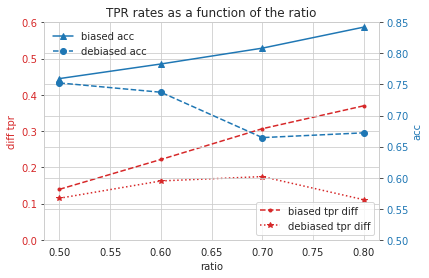

In [62]:
data2plot(plot_results)

In [18]:
results

defaultdict(dict,
            {0.5: {'p_acc': 0.517,
              'biased_diff_tpr': 0.19000000000000006,
              'debiased_diff_tpr': 0.16200000000000003,
              'biased_acc': 0.7595,
              'debiased_acc': 0.7525},
             0.6: {'p_acc': 0.6165,
              'biased_diff_tpr': 0.2891666666666667,
              'debiased_diff_tpr': 0.21500000000000008,
              'biased_acc': 0.783,
              'debiased_acc': 0.7375},
             0.7: {'p_acc': 0.623,
              'biased_diff_tpr': 0.3771428571428571,
              'debiased_diff_tpr': 0.24095238095238097,
              'biased_acc': 0.8085,
              'debiased_acc': 0.6645},
             0.8: {'p_acc': 0.6331331331331331,
              'biased_diff_tpr': 0.44906407035175877,
              'debiased_diff_tpr': 0.15108668341708542,
              'biased_acc': 0.8423423423423423,
              'debiased_acc': 0.6721721721721722}})

In [9]:
print('Ratio & Sentiment (Acc) & Sentiment + INLP (Acc) & Diff TPR & Diff TPR + INLP')
for ratio, vals in results.items():
    print('{} \t {:.2f} & \t {:.2f} & \t\t {:.2f} & \t\t {:.2f}'
          .format(ratio, vals['biased_acc'], vals['debiased_acc'], vals['biased_diff_tpr'], vals['debiased_diff_tpr'], '.2f'))

Ratio & Sentiment (Acc) & Sentiment + INLP (Acc) & Diff TPR & Diff TPR + INLP
0.5 	 0.76 & 	 0.75 & 		 0.15 & 		 0.12
0.6 	 0.76 & 	 0.71 & 		 0.24 & 		 0.18
0.7 	 0.74 & 	 0.65 & 		 0.32 & 		 0.16
0.8 	 0.72 & 	 0.62 & 		 0.41 & 		 0.16


# Accuracy - TPR rate tradeoff

In [22]:
ratio = 0.8
x_train, y_p_train, y_m_train = load_data(
        '../data/emoji_sent_race_{}/train/'.format(ratio),
        size=40000, ratio=ratio)
x_dev, y_p_dev, y_m_dev = load_data(
    '../data/emoji_sent_race_{}/dev/'.format(ratio),
    size=8000, ratio=ratio)

all_Ps = np.load('../data/emoji_sent_race_{}/P_svm.num-clfs=300.npy'.format(ratio), allow_pickle=True)
rowspaces = all_Ps[1]

In [23]:
from tqdm import tqdm_notebook as tqdm

In [24]:
len(rowspaces)

231

In [25]:
rowspaces[0].shape

(300, 300)

In [41]:
ratio_tradeoff = defaultdict(dict)

for p_iteration in tqdm(range(1, 201)):
    
    P = debias.get_projection_to_intersection_of_nullspaces(rowspaces[:p_iteration], input_dim=300)
    
    debiased_x_train = P.dot(x_train.T).T
    debiased_x_dev = P.dot(x_dev.T).T
    
    classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

    classifier.fit(debiased_x_train, y_m_train)
    debiased_score = classifier.score(debiased_x_dev, y_m_dev)
    
    _, debiased_diffs = get_TPR(y_m_dev, classifier.predict(debiased_x_dev), y_p_dev)
    
    ratio_tradeoff[p_iteration]['debiased_diff_tpr'] = debiased_diffs['y:0']
    ratio_tradeoff[p_iteration]['debiased_acc'] = debiased_score

In [1]:
# ratio_tradeoff

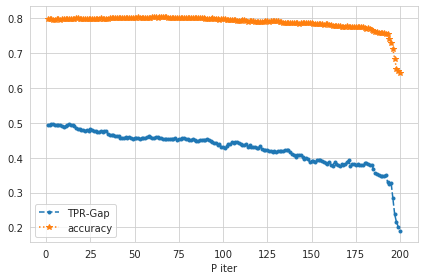

In [48]:
def data2plot(x, y1, y2, x_label=None, y_label=None, title=None):

    # label is optional, and is used for the legend
    # here, the third arguemtns are a mix of the `marker' and the `linestyle'
    ax = plt.plot(x, y1, '.--', label='TPR-Gap')
    ax = plt.plot(x, y2, '*:', label='accuracy')

    if y_label:
        plt.ylabel(y_label)
    if x_label:
        plt.xlabel(x_label)
    if title:
        plt.title(title)

    # Optional (and many times useful)
    # plt.ylim(0.5,0.90)
    plt.legend(loc='lower left', frameon=True)
    
    plt.tight_layout()
    # 
    plt.savefig('acc_tpr.pdf', dpi=1000)
    plt.show()
    
data2plot(list(ratio_tradeoff.keys()),
          [x['debiased_diff_tpr'] for x in ratio_tradeoff.values()],
          [x['debiased_acc'] for x in ratio_tradeoff.values()], 'P iter', title='')